In [0]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse 

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%cd '/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech'
#!git clone https://github.com/leeyeehoo/CSRNet-pytorch.git

/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech


In [0]:
%cd '/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch'

/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch


In [0]:
#importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from tqdm import tqdm
%matplotlib inline

In [0]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [0]:
model = CSRNet()


In [0]:
#defining the model
model = model.cuda()

In [0]:
#defining the location of dataset
root = '/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/'
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_B_train = os.path.join(root,'part_B/train_data','images')
part_B_test = os.path.join(root,'part_B/test_data','images')
path_sets = [part_A_test]

In [0]:
path_sets

['/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/part_A/test_data/images']

In [0]:
#defining the image path
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

In [0]:
#loading the trained weights
checkpoint = torch.load('/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/part_A/PartAmodel_best.pth.tar')

model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [0]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [0]:
import scipy.spatial

In [0]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/part_A/test_data/images/IMG_113.jpg
(506, 1024)
generate density...
done.
/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/part_A/test_data/images/IMG_139.jpg
(511, 1024)
generate density...
done.
/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/part_A/test_data/images/IMG_140.jpg
(768, 1024)
generate density...
done.
/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/part_A/test_data/images/IMG_96.jpg
(334, 540)
generate density...
done.
/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/part_A/test_data/images/IMG_19.jpg
(683, 1024)
generate density...
done.
/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/part_A/test_data/images/IMG_153.jpg
(400, 600)
generate density...
done.
/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-p

In [0]:
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground-truth'),'r')
    print(gt_file)
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

  0%|          | 0/182 [00:00<?, ?it/s]

<HDF5 file "IMG_111.h5" (mode r)>


  1%|          | 1/182 [00:00<02:25,  1.24it/s]

<HDF5 file "IMG_51.h5" (mode r)>


  1%|          | 2/182 [00:01<02:14,  1.33it/s]

<HDF5 file "IMG_110.h5" (mode r)>


  2%|▏         | 4/182 [00:02<01:46,  1.68it/s]

<HDF5 file "IMG_137.h5" (mode r)>
<HDF5 file "IMG_134.h5" (mode r)>


  3%|▎         | 5/182 [00:03<01:53,  1.56it/s]

<HDF5 file "IMG_91.h5" (mode r)>


  4%|▍         | 7/182 [00:04<01:39,  1.76it/s]

<HDF5 file "IMG_120.h5" (mode r)>
<HDF5 file "IMG_67.h5" (mode r)>


  4%|▍         | 8/182 [00:04<01:34,  1.84it/s]

<HDF5 file "IMG_129.h5" (mode r)>


  5%|▌         | 10/182 [00:05<01:24,  2.04it/s]

<HDF5 file "IMG_95.h5" (mode r)>


  6%|▌         | 11/182 [00:05<01:18,  2.18it/s]

<HDF5 file "IMG_3.h5" (mode r)>
<HDF5 file "IMG_119.h5" (mode r)>


  7%|▋         | 12/182 [00:06<01:25,  1.98it/s]

<HDF5 file "IMG_73.h5" (mode r)>


  7%|▋         | 13/182 [00:07<01:35,  1.78it/s]

<HDF5 file "IMG_84.h5" (mode r)>


  8%|▊         | 15/182 [00:08<01:29,  1.86it/s]

<HDF5 file "IMG_75.h5" (mode r)>
<HDF5 file "IMG_147.h5" (mode r)>


  9%|▉         | 16/182 [00:08<01:27,  1.91it/s]

<HDF5 file "IMG_173.h5" (mode r)>


 10%|▉         | 18/182 [00:09<01:23,  1.96it/s]

<HDF5 file "IMG_133.h5" (mode r)>
<HDF5 file "IMG_157.h5" (mode r)>


 10%|█         | 19/182 [00:10<01:30,  1.81it/s]

<HDF5 file "IMG_171.h5" (mode r)>


 11%|█         | 20/182 [00:11<01:38,  1.65it/s]

<HDF5 file "IMG_139.h5" (mode r)>


 12%|█▏        | 21/182 [00:11<01:32,  1.75it/s]

<HDF5 file "IMG_127.h5" (mode r)>


 13%|█▎        | 23/182 [00:12<01:22,  1.93it/s]

<HDF5 file "IMG_153.h5" (mode r)>


 13%|█▎        | 24/182 [00:13<01:10,  2.23it/s]

<HDF5 file "IMG_94.h5" (mode r)>
<HDF5 file "IMG_104.h5" (mode r)>


 14%|█▎        | 25/182 [00:13<01:17,  2.02it/s]

<HDF5 file "IMG_155.h5" (mode r)>


 14%|█▍        | 26/182 [00:14<01:25,  1.83it/s]

<HDF5 file "IMG_7.h5" (mode r)>


 15%|█▍        | 27/182 [00:14<01:26,  1.80it/s]

<HDF5 file "IMG_166.h5" (mode r)>


 16%|█▌        | 29/182 [00:15<01:13,  2.07it/s]

<HDF5 file "IMG_116.h5" (mode r)>


 16%|█▋        | 30/182 [00:16<01:11,  2.13it/s]

<HDF5 file "IMG_128.h5" (mode r)>
<HDF5 file "IMG_130.h5" (mode r)>


 17%|█▋        | 31/182 [00:16<01:10,  2.14it/s]

<HDF5 file "IMG_37.h5" (mode r)>


 18%|█▊        | 33/182 [00:19<02:08,  1.16it/s]

<HDF5 file "IMG_4.h5" (mode r)>
<HDF5 file "IMG_80.h5" (mode r)>


 19%|█▊        | 34/182 [00:20<01:55,  1.28it/s]

<HDF5 file "IMG_29.h5" (mode r)>


 19%|█▉        | 35/182 [00:20<01:47,  1.36it/s]

<HDF5 file "IMG_68.h5" (mode r)>


 20%|█▉        | 36/182 [00:21<01:42,  1.43it/s]

<HDF5 file "IMG_78.h5" (mode r)>


 21%|██        | 38/182 [00:22<01:20,  1.78it/s]

<HDF5 file "IMG_69.h5" (mode r)>
<HDF5 file "IMG_85.h5" (mode r)>


 21%|██▏       | 39/182 [00:22<01:20,  1.77it/s]

<HDF5 file "IMG_101.h5" (mode r)>


 22%|██▏       | 40/182 [00:23<01:23,  1.69it/s]

<HDF5 file "IMG_108.h5" (mode r)>


 23%|██▎       | 41/182 [00:24<01:22,  1.70it/s]

<HDF5 file "IMG_174.h5" (mode r)>


 23%|██▎       | 42/182 [00:24<01:24,  1.65it/s]

<HDF5 file "IMG_24.h5" (mode r)>


 24%|██▎       | 43/182 [00:25<01:23,  1.66it/s]

<HDF5 file "IMG_42.h5" (mode r)>


 24%|██▍       | 44/182 [00:25<01:26,  1.60it/s]

<HDF5 file "IMG_1.h5" (mode r)>


 25%|██▍       | 45/182 [00:26<01:25,  1.60it/s]

<HDF5 file "IMG_8.h5" (mode r)>


 25%|██▌       | 46/182 [00:27<01:23,  1.63it/s]

<HDF5 file "IMG_21.h5" (mode r)>


 26%|██▌       | 47/182 [00:27<01:22,  1.64it/s]

<HDF5 file "IMG_27.h5" (mode r)>


 26%|██▋       | 48/182 [00:28<01:24,  1.59it/s]

<HDF5 file "IMG_146.h5" (mode r)>


 27%|██▋       | 49/182 [00:28<01:18,  1.69it/s]

<HDF5 file "IMG_74.h5" (mode r)>


 28%|██▊       | 51/182 [00:29<01:09,  1.88it/s]

<HDF5 file "IMG_142.h5" (mode r)>
<HDF5 file "IMG_100.h5" (mode r)>


 29%|██▊       | 52/182 [00:30<01:04,  2.01it/s]

<HDF5 file "IMG_14.h5" (mode r)>


 29%|██▉       | 53/182 [00:30<01:08,  1.89it/s]

<HDF5 file "IMG_9.h5" (mode r)>


 30%|██▉       | 54/182 [00:31<01:14,  1.71it/s]

<HDF5 file "IMG_97.h5" (mode r)>


 30%|███       | 55/182 [00:32<01:19,  1.60it/s]

<HDF5 file "IMG_22.h5" (mode r)>


 31%|███       | 56/182 [00:32<01:12,  1.75it/s]

<HDF5 file "IMG_113.h5" (mode r)>


 32%|███▏      | 58/182 [00:33<01:04,  1.91it/s]

<HDF5 file "IMG_150.h5" (mode r)>
<HDF5 file "IMG_33.h5" (mode r)>


 32%|███▏      | 59/182 [00:34<01:04,  1.90it/s]

<HDF5 file "IMG_152.h5" (mode r)>


 33%|███▎      | 60/182 [00:35<01:08,  1.77it/s]

<HDF5 file "IMG_125.h5" (mode r)>


 34%|███▍      | 62/182 [00:35<00:59,  2.03it/s]

<HDF5 file "IMG_26.h5" (mode r)>
<HDF5 file "IMG_43.h5" (mode r)>


 35%|███▍      | 63/182 [00:36<01:02,  1.90it/s]

<HDF5 file "IMG_126.h5" (mode r)>


 35%|███▌      | 64/182 [00:37<01:06,  1.76it/s]

<HDF5 file "IMG_112.h5" (mode r)>


 36%|███▌      | 65/182 [00:37<01:09,  1.68it/s]

<HDF5 file "IMG_77.h5" (mode r)>


 36%|███▋      | 66/182 [00:38<01:11,  1.62it/s]

<HDF5 file "IMG_17.h5" (mode r)>


 37%|███▋      | 67/182 [00:39<01:37,  1.17it/s]

<HDF5 file "IMG_117.h5" (mode r)>


 38%|███▊      | 69/182 [00:40<01:13,  1.54it/s]

<HDF5 file "IMG_115.h5" (mode r)>
<HDF5 file "IMG_159.h5" (mode r)>


 39%|███▉      | 71/182 [00:41<00:55,  1.98it/s]

<HDF5 file "IMG_123.h5" (mode r)>


 40%|███▉      | 72/182 [00:42<00:51,  2.15it/s]

<HDF5 file "IMG_124.h5" (mode r)>


 40%|████      | 73/182 [00:42<00:48,  2.26it/s]

<HDF5 file "IMG_144.h5" (mode r)>
<HDF5 file "IMG_87.h5" (mode r)>


 41%|████      | 75/182 [00:43<00:48,  2.21it/s]

<HDF5 file "IMG_138.h5" (mode r)>
<HDF5 file "IMG_44.h5" (mode r)>


 42%|████▏     | 76/182 [00:44<00:54,  1.95it/s]

<HDF5 file "IMG_32.h5" (mode r)>


 42%|████▏     | 77/182 [00:44<00:57,  1.83it/s]

<HDF5 file "IMG_23.h5" (mode r)>


 43%|████▎     | 78/182 [00:45<01:07,  1.54it/s]

<HDF5 file "IMG_145.h5" (mode r)>


 43%|████▎     | 79/182 [00:46<01:07,  1.53it/s]

<HDF5 file "IMG_131.h5" (mode r)>


 44%|████▍     | 80/182 [00:46<01:06,  1.52it/s]

<HDF5 file "IMG_18.h5" (mode r)>


 45%|████▍     | 81/182 [00:47<01:06,  1.52it/s]

<HDF5 file "IMG_90.h5" (mode r)>


 45%|████▌     | 82/182 [00:48<01:00,  1.66it/s]

<HDF5 file "IMG_35.h5" (mode r)>


 46%|████▌     | 84/182 [00:48<00:51,  1.90it/s]

<HDF5 file "IMG_160.h5" (mode r)>
<HDF5 file "IMG_40.h5" (mode r)>


 47%|████▋     | 86/182 [00:50<01:01,  1.55it/s]

<HDF5 file "IMG_163.h5" (mode r)>
<HDF5 file "IMG_180.h5" (mode r)>


 48%|████▊     | 88/182 [00:51<00:53,  1.75it/s]

<HDF5 file "IMG_72.h5" (mode r)>
<HDF5 file "IMG_41.h5" (mode r)>


 49%|████▉     | 89/182 [00:52<00:56,  1.66it/s]

<HDF5 file "IMG_12.h5" (mode r)>


 50%|█████     | 91/182 [00:53<00:48,  1.87it/s]

<HDF5 file "IMG_98.h5" (mode r)>
<HDF5 file "IMG_141.h5" (mode r)>


 51%|█████     | 92/182 [00:53<00:49,  1.81it/s]

<HDF5 file "IMG_71.h5" (mode r)>


 51%|█████     | 93/182 [00:54<00:54,  1.63it/s]

<HDF5 file "IMG_25.h5" (mode r)>


 52%|█████▏    | 95/182 [01:00<02:11,  1.52s/it]

<HDF5 file "IMG_70.h5" (mode r)>


 53%|█████▎    | 96/182 [01:00<01:39,  1.15s/it]

<HDF5 file "IMG_136.h5" (mode r)>
<HDF5 file "IMG_10.h5" (mode r)>


 54%|█████▍    | 98/182 [01:01<01:09,  1.22it/s]

<HDF5 file "IMG_49.h5" (mode r)>
<HDF5 file "IMG_132.h5" (mode r)>


 54%|█████▍    | 99/182 [01:02<00:58,  1.41it/s]

<HDF5 file "IMG_86.h5" (mode r)>


 55%|█████▍    | 100/182 [01:04<01:28,  1.08s/it]

<HDF5 file "IMG_122.h5" (mode r)>


 56%|█████▌    | 102/182 [01:05<01:05,  1.22it/s]

<HDF5 file "IMG_107.h5" (mode r)>
<HDF5 file "IMG_168.h5" (mode r)>


 57%|█████▋    | 103/182 [01:05<01:01,  1.29it/s]

<HDF5 file "IMG_177.h5" (mode r)>


 57%|█████▋    | 104/182 [01:06<00:56,  1.39it/s]

<HDF5 file "IMG_48.h5" (mode r)>


 58%|█████▊    | 106/182 [01:07<00:41,  1.84it/s]

<HDF5 file "IMG_93.h5" (mode r)>
<HDF5 file "IMG_109.h5" (mode r)>


 59%|█████▉    | 108/182 [01:08<00:39,  1.90it/s]

<HDF5 file "IMG_96.h5" (mode r)>


 60%|█████▉    | 109/182 [01:08<00:34,  2.14it/s]

<HDF5 file "IMG_82.h5" (mode r)>
<HDF5 file "IMG_181.h5" (mode r)>


 61%|██████    | 111/182 [01:09<00:36,  1.93it/s]

<HDF5 file "IMG_65.h5" (mode r)>


 62%|██████▏   | 112/182 [01:10<00:33,  2.08it/s]

<HDF5 file "IMG_56.h5" (mode r)>
<HDF5 file "IMG_89.h5" (mode r)>


 63%|██████▎   | 114/182 [01:11<00:28,  2.36it/s]

<HDF5 file "IMG_61.h5" (mode r)>
<HDF5 file "IMG_50.h5" (mode r)>


 63%|██████▎   | 115/182 [01:11<00:36,  1.84it/s]

<HDF5 file "IMG_165.h5" (mode r)>


 64%|██████▍   | 117/182 [01:12<00:31,  2.08it/s]

<HDF5 file "IMG_102.h5" (mode r)>
<HDF5 file "IMG_36.h5" (mode r)>


 65%|██████▍   | 118/182 [01:13<00:39,  1.62it/s]

<HDF5 file "IMG_39.h5" (mode r)>


 66%|██████▌   | 120/182 [01:15<00:54,  1.15it/s]

<HDF5 file "IMG_143.h5" (mode r)>
<HDF5 file "IMG_79.h5" (mode r)>


 66%|██████▋   | 121/182 [01:16<00:49,  1.24it/s]

<HDF5 file "IMG_13.h5" (mode r)>


 68%|██████▊   | 123/182 [01:17<00:36,  1.61it/s]

<HDF5 file "IMG_16.h5" (mode r)>
<HDF5 file "IMG_170.h5" (mode r)>


 69%|██████▊   | 125/182 [01:18<00:30,  1.86it/s]

<HDF5 file "IMG_167.h5" (mode r)>
<HDF5 file "IMG_156.h5" (mode r)>


 70%|██████▉   | 127/182 [01:19<00:26,  2.08it/s]

<HDF5 file "IMG_176.h5" (mode r)>
<HDF5 file "IMG_30.h5" (mode r)>


 70%|███████   | 128/182 [01:19<00:26,  2.07it/s]

<HDF5 file "IMG_118.h5" (mode r)>


 71%|███████▏  | 130/182 [01:20<00:24,  2.09it/s]

<HDF5 file "IMG_151.h5" (mode r)>
<HDF5 file "IMG_19.h5" (mode r)>


 73%|███████▎  | 132/182 [01:21<00:24,  2.04it/s]

<HDF5 file "IMG_76.h5" (mode r)>
<HDF5 file "IMG_83.h5" (mode r)>


 73%|███████▎  | 133/182 [01:22<00:26,  1.84it/s]

<HDF5 file "IMG_106.h5" (mode r)>


 74%|███████▎  | 134/182 [01:22<00:25,  1.88it/s]

<HDF5 file "IMG_179.h5" (mode r)>


 74%|███████▍  | 135/182 [01:23<00:26,  1.77it/s]

<HDF5 file "IMG_11.h5" (mode r)>


 75%|███████▌  | 137/182 [01:24<00:23,  1.89it/s]

<HDF5 file "IMG_99.h5" (mode r)>
<HDF5 file "IMG_6.h5" (mode r)>


 76%|███████▌  | 138/182 [01:25<00:24,  1.82it/s]

<HDF5 file "IMG_178.h5" (mode r)>


 77%|███████▋  | 140/182 [01:26<00:21,  1.96it/s]

<HDF5 file "IMG_54.h5" (mode r)>
<HDF5 file "IMG_175.h5" (mode r)>


 77%|███████▋  | 141/182 [01:26<00:21,  1.93it/s]

<HDF5 file "IMG_45.h5" (mode r)>


 78%|███████▊  | 142/182 [01:27<00:20,  1.93it/s]

<HDF5 file "IMG_64.h5" (mode r)>


 79%|███████▊  | 143/182 [01:27<00:19,  1.97it/s]

<HDF5 file "IMG_161.h5" (mode r)>


 80%|███████▉  | 145/182 [01:28<00:15,  2.33it/s]

<HDF5 file "IMG_34.h5" (mode r)>


 80%|████████  | 146/182 [01:28<00:14,  2.45it/s]

<HDF5 file "IMG_162.h5" (mode r)>
<HDF5 file "IMG_88.h5" (mode r)>


 81%|████████▏ | 148/182 [01:29<00:16,  2.08it/s]

<HDF5 file "IMG_59.h5" (mode r)>
<HDF5 file "IMG_103.h5" (mode r)>


 82%|████████▏ | 150/182 [01:30<00:15,  2.12it/s]

<HDF5 file "IMG_15.h5" (mode r)>


 83%|████████▎ | 151/182 [01:31<00:13,  2.29it/s]

<HDF5 file "IMG_47.h5" (mode r)>


 84%|████████▎ | 152/182 [01:31<00:11,  2.51it/s]

<HDF5 file "IMG_164.h5" (mode r)>


 84%|████████▍ | 153/182 [01:31<00:11,  2.47it/s]

<HDF5 file "IMG_62.h5" (mode r)>
<HDF5 file "IMG_121.h5" (mode r)>


 85%|████████▌ | 155/182 [01:32<00:11,  2.35it/s]

<HDF5 file "IMG_52.h5" (mode r)>
<HDF5 file "IMG_38.h5" (mode r)>


 86%|████████▌ | 156/182 [01:33<00:12,  2.10it/s]

<HDF5 file "IMG_63.h5" (mode r)>


 86%|████████▋ | 157/182 [01:34<00:13,  1.84it/s]

<HDF5 file "IMG_114.h5" (mode r)>


 87%|████████▋ | 158/182 [01:34<00:13,  1.73it/s]

<HDF5 file "IMG_182.h5" (mode r)>


 88%|████████▊ | 160/182 [01:35<00:12,  1.81it/s]

<HDF5 file "IMG_148.h5" (mode r)>
<HDF5 file "IMG_5.h5" (mode r)>


 88%|████████▊ | 161/182 [01:36<00:12,  1.68it/s]

<HDF5 file "IMG_55.h5" (mode r)>


 89%|████████▉ | 162/182 [01:37<00:11,  1.67it/s]

<HDF5 file "IMG_20.h5" (mode r)>


 90%|████████▉ | 163/182 [01:37<00:11,  1.64it/s]

<HDF5 file "IMG_2.h5" (mode r)>


 91%|█████████ | 165/182 [01:39<00:09,  1.71it/s]

<HDF5 file "IMG_81.h5" (mode r)>
<HDF5 file "IMG_140.h5" (mode r)>


 92%|█████████▏| 167/182 [01:40<00:08,  1.85it/s]

<HDF5 file "IMG_53.h5" (mode r)>


 92%|█████████▏| 168/182 [01:40<00:07,  1.97it/s]

<HDF5 file "IMG_158.h5" (mode r)>


 93%|█████████▎| 169/182 [01:40<00:06,  2.12it/s]

<HDF5 file "IMG_172.h5" (mode r)>


 93%|█████████▎| 170/182 [01:41<00:05,  2.17it/s]

<HDF5 file "IMG_154.h5" (mode r)>
<HDF5 file "IMG_66.h5" (mode r)>


 95%|█████████▍| 172/182 [01:42<00:04,  2.27it/s]

<HDF5 file "IMG_135.h5" (mode r)>
<HDF5 file "IMG_31.h5" (mode r)>


 95%|█████████▌| 173/182 [01:43<00:04,  1.88it/s]

<HDF5 file "IMG_28.h5" (mode r)>


 96%|█████████▌| 174/182 [01:43<00:04,  1.81it/s]

<HDF5 file "IMG_105.h5" (mode r)>


 96%|█████████▌| 175/182 [01:44<00:03,  1.75it/s]

<HDF5 file "IMG_46.h5" (mode r)>


 97%|█████████▋| 176/182 [01:44<00:03,  1.73it/s]

<HDF5 file "IMG_92.h5" (mode r)>


 97%|█████████▋| 177/182 [01:45<00:02,  1.77it/s]

<HDF5 file "IMG_149.h5" (mode r)>


 98%|█████████▊| 178/182 [01:46<00:02,  1.67it/s]

<HDF5 file "IMG_169.h5" (mode r)>


 98%|█████████▊| 179/182 [01:46<00:01,  1.62it/s]

<HDF5 file "IMG_58.h5" (mode r)>


 99%|█████████▉| 180/182 [01:47<00:01,  1.56it/s]

<HDF5 file "IMG_60.h5" (mode r)>


 99%|█████████▉| 181/182 [01:47<00:00,  1.67it/s]

<HDF5 file "IMG_57.h5" (mode r)>


100%|██████████| 182/182 [01:48<00:00,  1.64it/s]

75.69744665544111


/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch
Predicted Count :  368


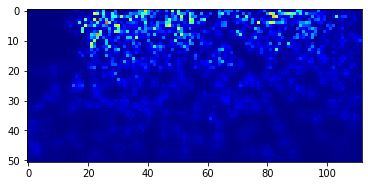

Original Count :  382


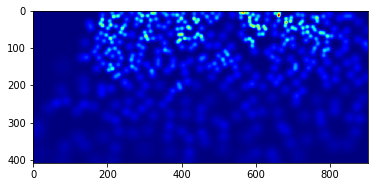

Original Image


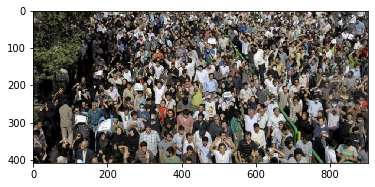

In [0]:
from matplotlib import cm as c
%cd '/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/'
img = transform(Image.open('part_A/test_data/images/IMG_100.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('part_A/test_data/ground-truth/IMG_100.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('part_A/test_data/images/IMG_100.jpg'))
plt.show()

In [0]:
#DEMO
%cd '/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST'

/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST


Predicted Count :  127


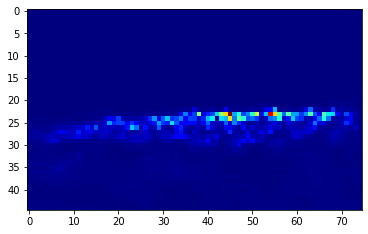

Original Image


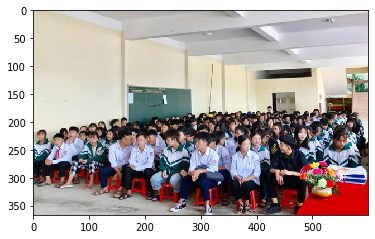

In [0]:
from matplotlib import cm as c
img = transform(Image.open('150ae.jpg').convert('RGB')).cuda()
output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
print("Original Image")
plt.imshow(plt.imread('150ae.jpg'))
plt.show()

Predicted Count :  377


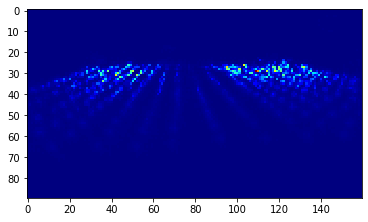

Original Image


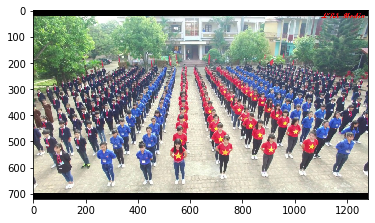

In [0]:
img = transform(Image.open('400ae.jpg').convert('RGB')).cuda()
output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
print("Original Image")
plt.imshow(plt.imread('400ae.jpg'))
plt.show()

In [0]:
%cd '/content/gdrive/My Drive/Git'

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Git'
/content/gdrive/My Drive/Colab Notebooks/CCDemo/TEST/ShanghaiTech/CSRNet-pytorch/part_A


In [0]:
!git clone 